<a href="https://colab.research.google.com/github/vdslab/t-taiki0620/blob/main/visdata%E3%81%AE%E6%8A%BD%E5%87%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import csv
import pandas as pd
import numpy

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/pre-judgit/IEEE VIS papers 1990-2020 - Main dataset.csv', encoding='utf8')as f:
  df = pd.read_csv(f)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Conference                     3394 non-null   object 
 1   Year                           3394 non-null   int64  
 2   Title                          3394 non-null   object 
 3   DOI                            3394 non-null   object 
 4   Link                           3394 non-null   object 
 5   FirstPage                      3361 non-null   object 
 6   LastPage                       3351 non-null   object 
 7   PaperType                      3394 non-null   object 
 8   Abstract                       3321 non-null   object 
 9   AuthorNames-Deduped            3394 non-null   object 
 10  AuthorNames                    3390 non-null   object 
 11  AuthorAffiliation              3263 non-null   object 
 12  InternalReferences             2638 non-null   o

In [ ]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
trainings = []
for i in range(len(df)):
  try:
    trainings.append(TaggedDocument(df.loc[i]['Abstract'].split(), [i]))
  except:
    pass

In [ ]:
model = Doc2Vec(trainings, epochs=30, min_alpha=1e-4, sample=1e-3, min_count=4, window=15, vector_size=50)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/pre-judgit/VIS1990-2020.model')

In [ ]:
model = Doc2Vec.load('/content/drive/MyDrive/Colab Notebooks/pre-judgit/VIS1990-2020.model')

In [ ]:
samples_list = []
df_exp = []
for i in range(len(trainings)):
  tmp = {}
  ind = df.index.get_loc(trainings[i].tags[0])
  if numpy.isnan(float('NaN')) != df.loc[ind]['AuthorKeywords']:
    tmp['Title'] = df.loc[ind]['Title']
    tmp['Abstract'] = df.loc[ind]['Abstract']
    try:
      tmp['AuthorKeywords'] = df.loc[ind]['AuthorKeywords'].split()
    except:
      tmp['AuthorKeywords'] = []
    df_exp.append(model.docvecs[trainings[i].tags[0]])
    samples_list.append(tmp)
  if i%1000 == 0:
    print('doing')

doing
doing
doing
doing


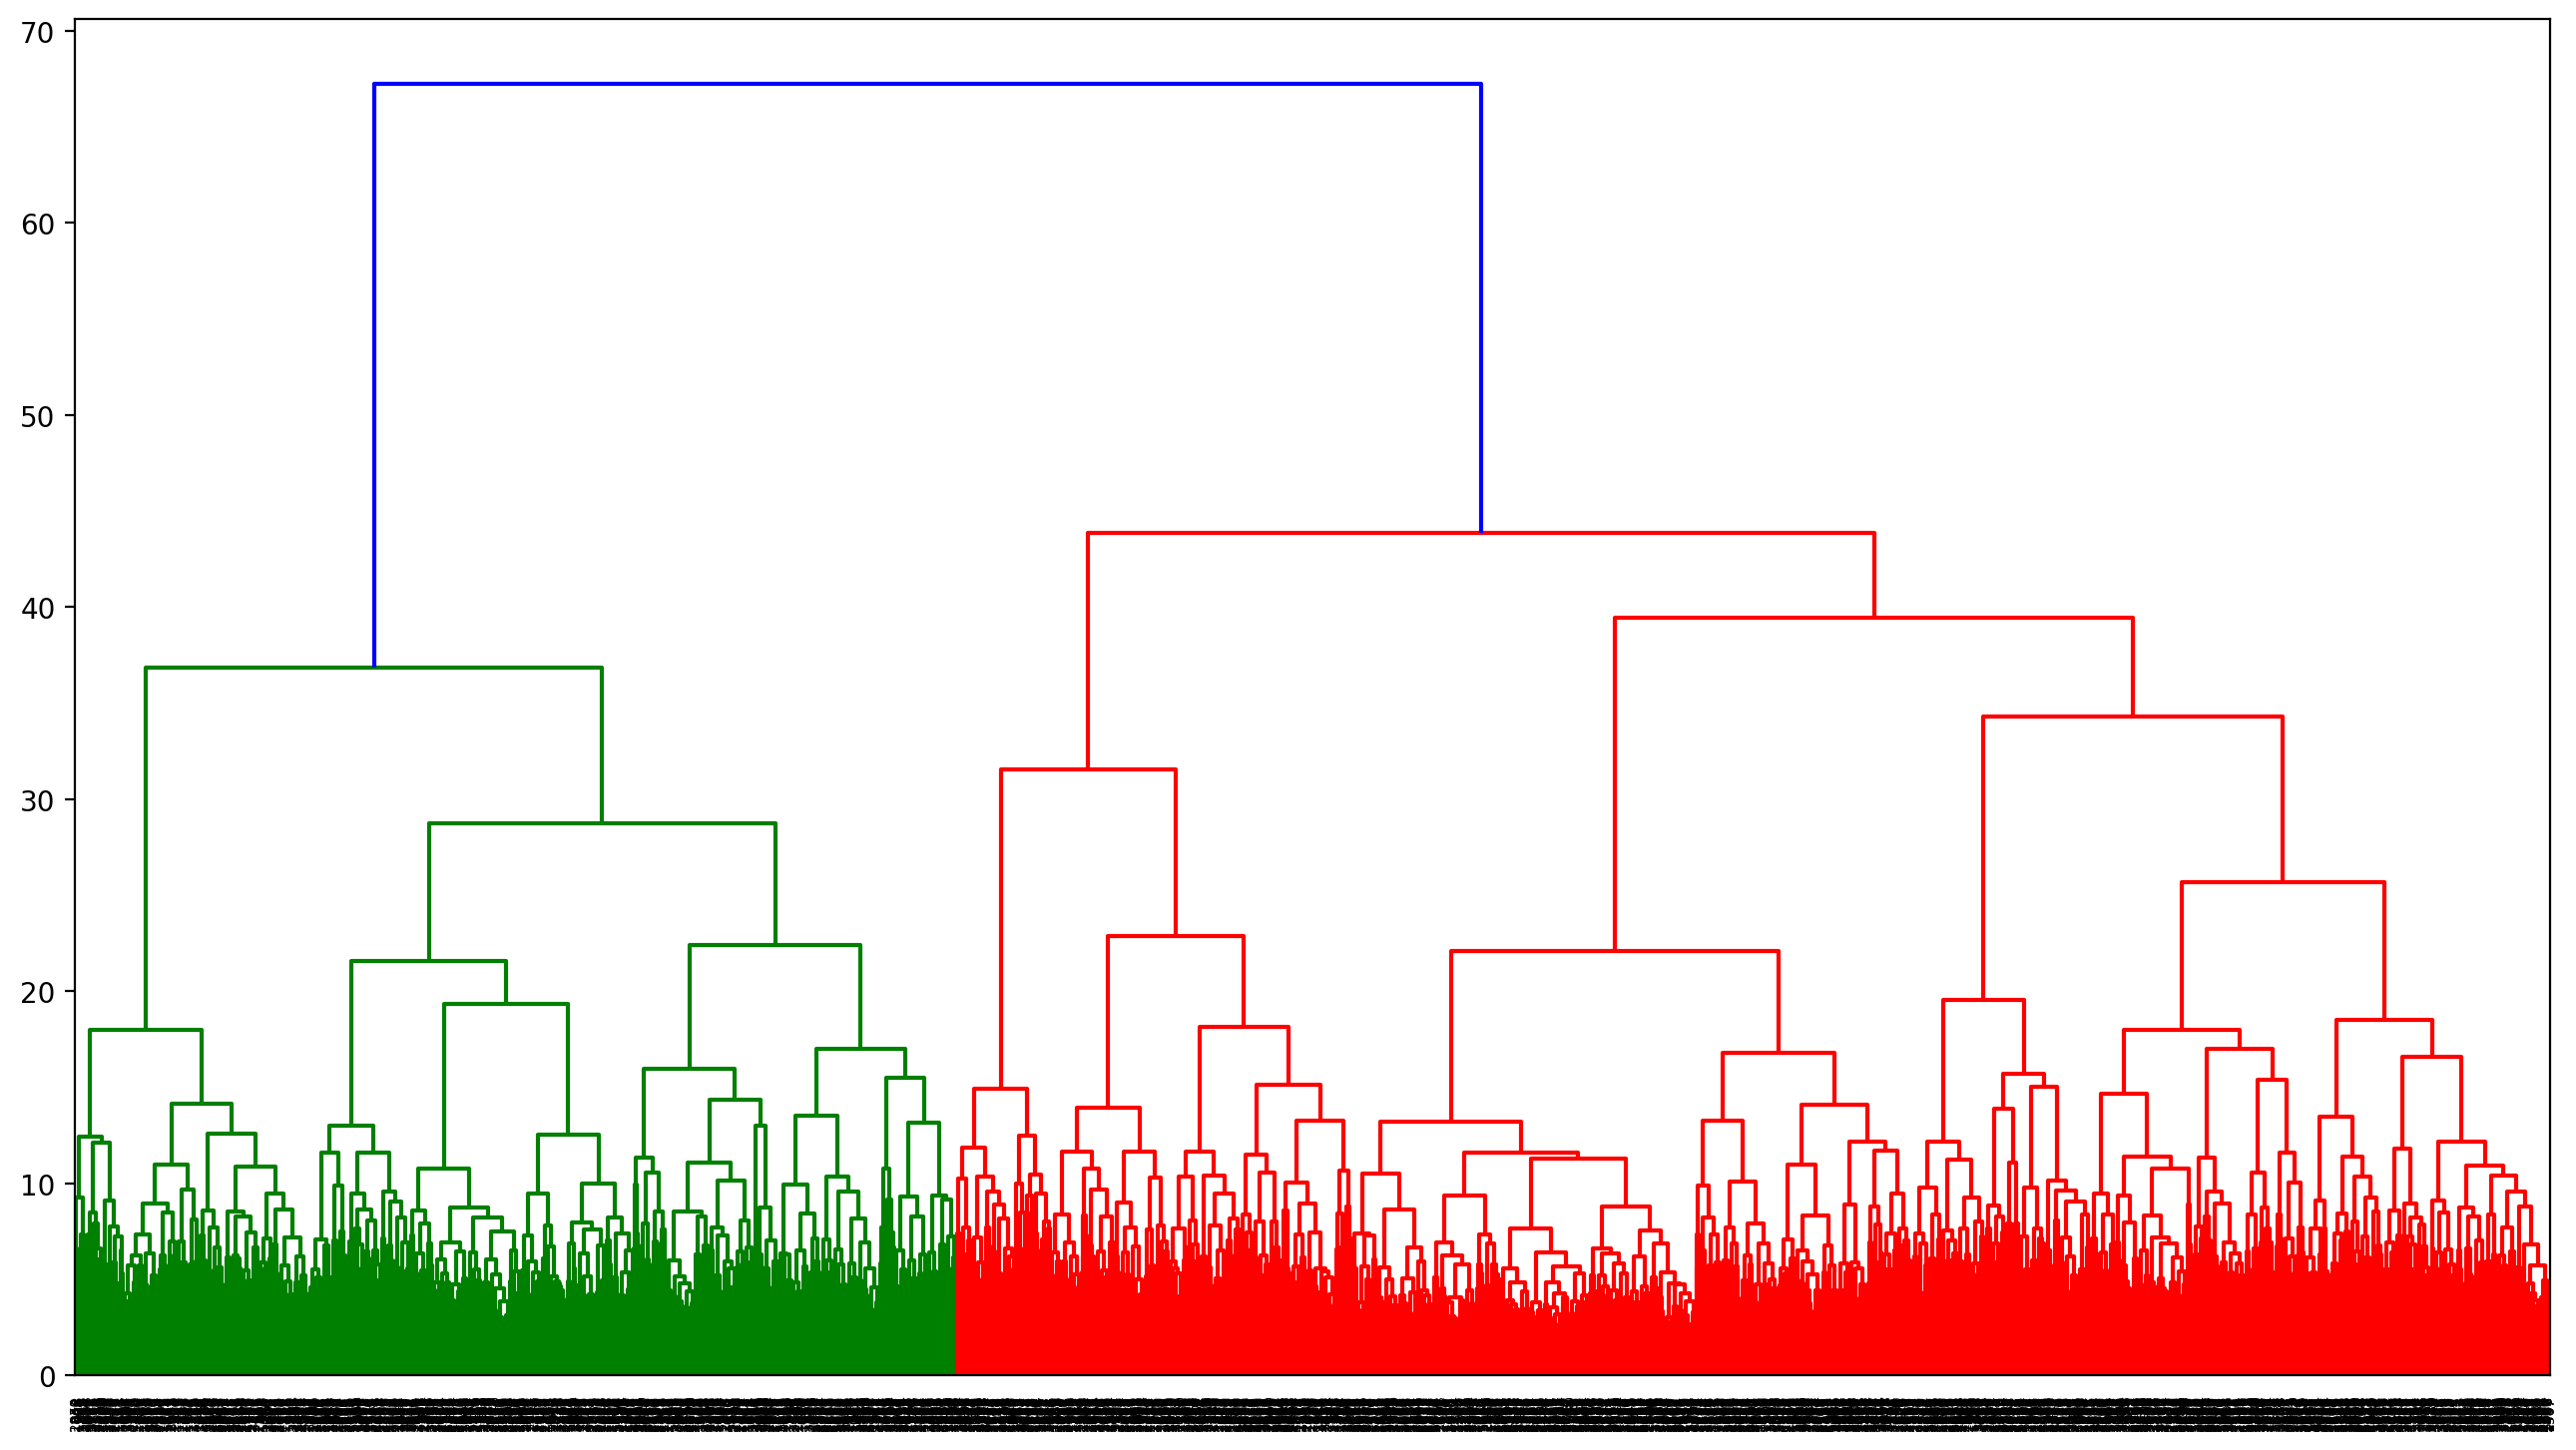

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
 
linkage_result = linkage(df_exp, method='ward', metric='euclidean')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result, labels=df.index)
plt.show()

In [ ]:
!pip install git+https://github.com/boudinfl/pke.git
!python -m nltk.downloader stopwords
!python -m nltk.downloader universal_tagset
!python -m spacy download en_core_web_sm # download the english model

  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-_expph5t
  Running command git clone -q https://github.com/boudinfl/pke.git /tmp/pip-req-build-_expph5t
     |████████████████████████████████| 235 kB 5.1 MB/s 
  Created wheel for pke: filename=pke-1.8.1-py3-none-any.whl size=8764035 sha256=02e4bd4d5b2bbe176c512b9d537f03bed40c432fd1ac8f115f37e2cf0d873973
  Stored in directory: /tmp/pip-ephem-wheel-cache-sd75xg9w/wheels/fa/b3/09/612ee93bf3ee4164bcd5783e742942cdfc892a86039d3e0a33
Successfully built pke
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior

pkeのdocumentを読む

In [ ]:
import pke
import sys

sys.setrecursionlimit(10000)
def get_key_phrase(text, n = 5):
    """キーフレーズ処理

    Args:
        text ([type]): キーフレーズ対象の文字列
        n (int, optional): [description]. Defaults to 10.
        gc_collect (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    #MultipartiteRankなどのキーフレーズの手法については以下のサイトが参考になります
    #https://www.ogis-ri.co.jp/otc/hiroba/technical/similar-document-search/part5.html
    extractor = pke.unsupervised.MultipartiteRank()
    extractor.load_document(input=text, language='en')
    extractor.candidate_selection()
    extractor.candidate_weighting(threshold=0.74, method='average', alpha=1.1)
    key_phrase = extractor.get_n_best(n)
    
    return  key_phrase
    
    
#spacyに設定されているstopwordを使う
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_pke = {}
df_enpty = []
for i in range(len(samples_list)):
  pke_test = {}
  for words in get_key_phrase(samples_list[i]['Abstract']):
    for word in words[0].split():
      if word in pke_test:
        pke_test[word] += words[1]
      else:
        pke_test[word] = words[1]

  df_pke[samples_list[i]['Title']] = pke_test
  if i % 500 == 0:
    print(df_pke[samples_list[i]['Title']])

{'novel': 0.09499765414441311, 'representation': 0.09499765414441311, 'data': 0.0786458467582725, 'transparent': 0.07442014062323143, 'approach': 0.07442014062323143, 'documents': 0.06506261017642279, 'visualization': 0.04704243515034964}
{'domain': 0.05819691859338583, 'experts': 0.05819691859338583, 'evaluation': 0.056235590767543586, 'groups': 0.05471581143726882, 'research': 0.0517921940948385, 'goal': 0.05095899534248677}
{'twitter': 0.11687001888986476, 'tweets': 0.08249329751541506, 'opinions': 0.04933091098830689, 'topics': 0.040704041072813814, 'large': 0.04027119779410551, 'number': 0.04027119779410551}
{'complex': 0.06049549652321821, 'sets': 0.06049549652321821, 'differences': 0.05644672115584749, 'images': 0.054734513848413796, 'data': 0.04431656726820678, 'analysis': 0.04040706429954716}
{'gridded': 0.11054072076990354, 'data': 0.11054072076990354, 'experience': 0.05858727101403499, 'complete': 0.0501112129063023, 'sets': 0.0501112129063023, 'shelf': 0.04710373578926365, 

In [ ]:
for i in range(len(samples_list)):
  word_score = []
  tmp_list = sorted(df_pke[samples_list[i]['Title']].items(), key=lambda x: x[1], reverse=True)
  for data in tmp_list:
    word_score.append({"word" : data[0],
                      "score" : data[1]})
  samples_list[i]['MultipartiteRank'] = word_score

In [ ]:
obj = []
for i in range(len(samples_list)):
  obj.append({"no":str(int(i)),
              "parent":"",
              "distance":0,
              "Title":samples_list[i]["Title"],
              "Abstract":samples_list[i]["Abstract"],
              "AuthorKeywords":samples_list[i]["AuthorKeywords"],
              "MultipartiteRank":samples_list[i]["MultipartiteRank"]
              })

for i in range(len(linkage_result)):
  obj.append({"no":str(len(linkage_result)+i+1),
              "parent":"",
              "distance":linkage_result[i][2],
              "Title":"",
              "Abstract":"",
              "AuthorKeywords":[],
              "MultipartiteRank":[]
              })

for i in range(len(obj)):
  if i % 1000 == 0 :
    print("running", i)
  for j in range(len(linkage_result)):
    if int(obj[i]["no"]) == linkage_result[j][0] or int(obj[i]["no"]) == linkage_result[j][1]:
      obj[i]["parent"] = str(len(linkage_result)+j+1)

running 0
running 1000
running 2000
running 3000
running 4000
running 5000
running 6000


In [ ]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/pre-judgit/test1018.json', 'w', encoding='utf8')as f:
  json.dump(obj, f, indent = 2, ensure_ascii=False)

In [ ]:
words_array = []
for i in range(len(samples_list)):
  if i%1000 == 0:
    print(i)
  try:
    for words in samples_list[i]['MultipartiteRank']:
      if words["word"] not in words_array:
        words_array.append(words["word"])
  except:
    print(i)

0
1000
2000
3000


In [ ]:
vector_data = []
no_vectors_word = []
for word in words_array:
  try:
    tmp = {"word":word, "vector":list(float(x) for x in model.infer_vector(word))}
    vector_data.append(tmp)
  except:
    no_vectors_word.append(word)

In [ ]:
print(len(vector_data), len(no_vectors_word))

4578 0


In [ ]:
import json
with open("/content/drive/MyDrive/Colab Notebooks/pre-judgit/word_vector1018.json", 'w', encoding="utf8")as f:
  json.dump(vector_data, f, indent=2, ensure_ascii=False)

In [ ]:
import json
with open('/content/drive/MyDrive/Colab Notebooks/pre-judgit/test1018.json', encoding='utf8')as f:
  obj = json.load(f)

In [ ]:
df.loc[0]

Conference                                                                 InfoVis
Year                                                                          2011
Title                                                     D³ Data-Driven Documents
DOI                                                          10.1109/TVCG.2011.185
Link                                       http://dx.doi.org/10.1109/TVCG.2011.185
FirstPage                                                                     2301
LastPage                                                                      2309
PaperType                                                                        J
Abstract                         Data-Driven Documents (D3) is a novel represen...
AuthorNames-Deduped                  Michael Bostock;Vadim Ogievetsky;Jeffrey Heer
AuthorNames                          Michael Bostock;Vadim Ogievetsky;Jeffrey Heer
AuthorAffiliation                                                              NaN
Inte

In [ ]:
for data in obj:
  data.append()

[{'Abstract': 'Data-Driven Documents (D3) is a novel representation-transparent approach to visualization for the web. Rather than hide the underlying scenegraph within a toolkit-specific abstraction, D3 enables direct inspection and manipulation of a native representation: the standard document object model (DOM). With D3, designers selectively bind input data to arbitrary document elements, applying dynamic transforms to both generate and modify content. We show how representational transparency improves expressiveness and better integrates with developer tools than prior approaches, while offering comparable notational efficiency and retaining powerful declarative components. Immediate evaluation of operators further simplifies debugging and allows iterative development. Additionally, we demonstrate how D3 transforms naturally enable animation and interaction with dramatic performance improvements over intermediate representations.',
  'AuthorKeywords': ['Information',
   'visualiza

In [ ]:
for i in range(len(trainings)):
  tmp = {}
  ind = df.index.get_loc(trainings[i].tags[0])
  if numpy.isnan(float('NaN')) != df.loc[ind]['AuthorKeywords']:
    tmp['Title'] = df.loc[ind]['Title']
    tmp['Abstract'] = df.loc[ind]['Abstract']
    try:
      tmp['AuthorKeywords'] = df.loc[ind]['AuthorKeywords'].split()
    except:
      tmp['AuthorKeywords'] = []
    df_exp.append(model.docvecs[trainings[i].tags[0]])
    samples_list.append(tmp)
  if i%1000 == 0:
    print('doing')